In [56]:
import networkx as nx
import numpy as np
from itertools import groupby
from numpy.random import choice,random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from collections import defaultdict
from random import choice
from timeit import default_timer as timer
from fractions import Fraction

%matplotlib inline
# to visualize matrices in fraction format
np.set_printoptions(formatter={'all':lambda x: str(Fraction(x).limit_denominator())})

## Problem 3

Let $\omega = Λ1$.

In [57]:
Lambda_open = np.array([[0,  3/4, 3/8, 0,   0],
               [0,  0,   1/4, 1/4, 2/4],
               [0,  0,   0,   1,   0],
               [0,  0,   0,   0,   1],
               [0,  0,   0,   0,   0]])
w = np.dot(Lambda_open, np.ones(5))
w

array([9/8, 1, 1, 1, 0])

{('o', 'a'): Text(0.5, 1.0, '3/4'),
 ('o', 'b'): Text(0.5, -1.0, '3/8'),
 ('a', 'b'): Text(1.0, 0.0, '1/4'),
 ('a', 'c'): Text(1.5, 0.0, '1/4'),
 ('a', 'd'): Text(1.5, 2.0, '1/2'),
 ('b', 'c'): Text(1.5, -2.0, '1'),
 ('c', 'd'): Text(2.0, 0.0, '1')}

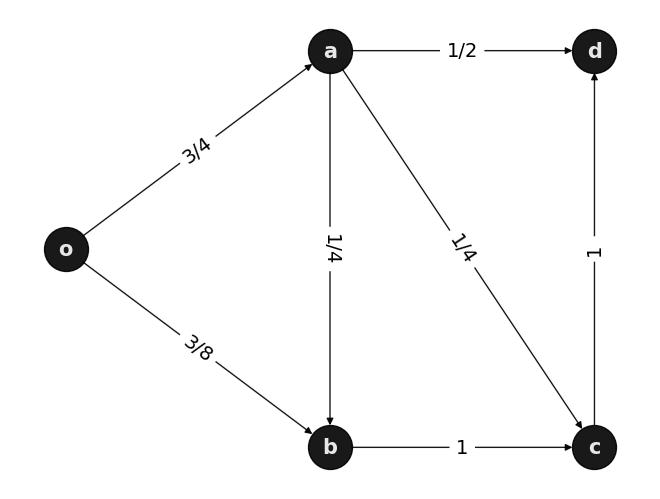

In [58]:
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', 3/4), ('o', 'b', 3/8), ('a', 'b', 1/4),
                           ('a', 'c', 1/4), ('a', 'd', 2/4), ('b', 'c', 1),
                           ('c','d', 1)])

pos = {'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos, with_labels = True, node_size=1000, node_color='black',
        font_color='white', font_weight='bold', font_size=15, alpha=0.9)
labels = {e : Fraction(G.edges[e]['weight']) for e in G.edges} # 'edge' : 'weight'
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='black', font_size=14)

For nodes $i$ such that $\omega_i=0$ (which means that once the process in $i$ it remains $i$ forever), we need to add a selfloop $\Lambda_{ii}>0$, otherwise the matrix $P$ is not well defined (it would mean dividing the matrix P by 0). Since node $d$ does not have a node to send its particles to, we can proceed equivalently in one of these two following ways:
1. assume that $\omega_{d} = 2$;
2. (what we implemented) think of another node $d'$ connected to node $d$, such that at every tick of the Poisson clock of $d$, it sends a particle to node $d'$: $w_d=1,\ w_{d'}=1$.

For this system, particles will enter the system at node $o$ according to a Poisson process with input rate $\lambda = 1$. In order to simulate the entrance of the particles in the system, we create a new node $o'$ connected to $o$ such that the rate for its associated Poisson clock equals the input rate: $\omega_{o'} = \lambda$. Note that the number of particles inside the source $o'$ equals the input rate at every time instant.

In [59]:
Lambda_augmented = np.zeros((7,7)) # we add node o' as the start node at index=0
Lambda_augmented[1:6, 1:6] = Lambda_open
Lambda_augmented[0,1] = 1 # o --> o'
Lambda_augmented[5,6] = 1 # d self loop
Lambda_augmented[6,5] = 1 # d self loop
print(Lambda_augmented)

[[0 1 0 0 0 0 0]
 [0 0 3/4 3/8 0 0 0]
 [0 0 0 1/4 1/4 1/2 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


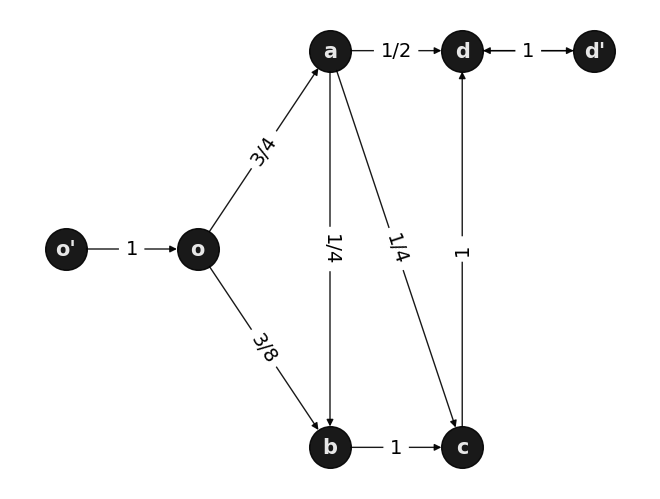

In [60]:
G = nx.DiGraph()
G.add_nodes_from(["o'",'o','a','b','c','d', "d'"])
G.add_weighted_edges_from([('o', 'a', 3/4), ('o', 'b', 3/8), ('a', 'b', 1/4),
                           ('a', 'c', 1/4), ('a', 'd', 2/4), ('b', 'c', 1),
                           ('c','d', 1), ('d', "d'", 1), ("d'", "d", 1), ("o'", 'o', 1)])

pos = {"o'": (-1,0), 'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2), "d'":(3,2)}
nx.draw(G, pos, with_labels = True, node_size=900, node_color='black',
        font_color='white', font_weight='bold', font_size=15, alpha=0.9)
labels = {e : Fraction(G.edges[e]['weight']) for e in G.edges} # 'edge' : 'weight'
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='black', font_size=14)
plt.savefig("Lambda.pdf")

In [61]:
w = np.dot(Lambda_augmented, np.ones(7))
D = np.diag(w)
P = np.dot(np.linalg.inv(D), Lambda_augmented)
print("Matrix w\n",w,"\n")
print("Matrix D\n",D,"\n")
print("Matrix P\n",P,"\n")

Matrix w
 [1 9/8 1 1 1 1 1] 

Matrix D
 [[1 0 0 0 0 0 0]
 [0 9/8 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]] 

Matrix P
 [[0 1 0 0 0 0 0]
 [0 0 2/3 1/3 0 0 0]
 [0 0 0 1/4 1/4 1/2 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]] 



In [62]:
# max_time = 60 simulate the system for 60 time units
# input_rate = 1 rate of the Poisson process according to which the particles will enter at node o
def simulation(max_time, input_rate, fixed):
    # HISTORY
    # n.of particles evolution for each node: it stores the n.of particles everytime it changes
    nodes_particles_dict = defaultdict(lambda:[]) # init: empty list = no history
    # ticks of Poisson clock for each node: it stores the time instant whenever the local clock ticks
    nodes_ticks_dict = defaultdict(lambda:[]) # init: empty list = no history

    # LAST UPDATE
    # n.of particles in each node registered after the last update
    # init: 0 particles in every node, except node o' = input_rate
    num_particles = defaultdict(lambda: 0)
    num_particles[0] = input_rate
    # tick of Poisson clock for each node measured after the last update
    time_clock_dict = defaultdict(lambda: 0) # init: our study starts from time=0 in all the nodes
    # node_i's waiting random time for next transition, according to its distribution defined by num_particles[i]*w[i]
    # init: since all the nodes, except o', are without particles, waiting time in every node is set to inf
    t_next = defaultdict(lambda: np.inf)
    if not fixed:
        t_next[0] = -np.log(np.random.rand())/(num_particles[0]*w[0])
    else:
        t_next[0] = -np.log(np.random.rand())/input_rate
    # init: time instant of the last update set to -1 in order to avoid its effect at the beginning of the simulation
    last_update_time = -1

    #index_while=0

    # while there is at least one valid scheduled transition time,
    # i.e. among the next transitions for all the nodes, there exists >= 1 whose time instant is before the max_time
    # Note: do not consider the scheduled transition time for "d" since it sends its particles only to a fictitious node
    while (time_clock_dict[0] + t_next[0] <= max_time or
           time_clock_dict[1] + t_next[1] <= max_time or
           time_clock_dict[2] + t_next[2] <= max_time or
           time_clock_dict[3] + t_next[3] <= max_time or
           time_clock_dict[4] + t_next[4] <= max_time):

        #index_while+=1
        #print("\n", index_while)
        #[print("node", i, "time_clock_dict:", time_clock_dict[i], "+ t_next", t_next[i],
               #"sum", time_clock_dict[i] + t_next[i]) for i in range(0,6)]

        # minimum scheduled time for next transition: related to the node that will update before the other ones
        min_time = max_time # init: = max possible value
        # find the nodes having the smallest min_time, i.e. the nodes which have the transition before the other ones
        # Note: at the same time instant, there could exist more than one node updating its number of particles
        for node in range(0,6): # (o',o,a,b,c,d)
            # consider only the nodes with some particles: the nodes without particles cannot update
            if num_particles[node] > 0:
                # a node can have its next update scheduled before the last global update,
                # due to the fact that at its scheduled time it had no particles inside,
                # i.e. that node did not enter into this 'if' at its scheduled time, so time_clock_dict wasn't updated
                # Example:
                #   - last_update_time: time instant of the last update = 5s
                #   - transition_times[node]: time instant when transition (should) happen(s) = 1s
                #   - t_next[node]: waiting time for next transition = 2s
                #   >> scheduled time for transition of the node = 3s is before the last update = 5s
                #   >> the transition cannot happen at time t = 3s and cannot happen while t < 5s.
                while time_clock_dict[node] + t_next[node] < last_update_time:
                    # we postpone the update s.t. it is >= last_update_time
                    # Example:
                    #   1+2 < 5 yes, stay here
                    #   3+2 < 5 no, exit
                    #   >> transition_times = 5: the node update has been postponed from t = 3s to t = 5s
                    time_clock_dict[node] += t_next[node]
                    if not fixed:
                        t_next[node] = -np.log(np.random.rand())/(num_particles[node]*w[node]) # for next transition
                    else:
                        if node==0:
                            t_next[node] = -np.log(np.random.rand())/input_rate # for next transition
                        else:
                            t_next[node] = -np.log(np.random.rand())/w[node]
                # find the minimum scheduled time for next transition among all the nodes
                if time_clock_dict[node] + t_next[node] < min_time:
                    min_time = time_clock_dict[node] + t_next[node]

        nodes_to_update = [] # contains the nodes s.t. their scheduled time = the first time available for next jump
        for node in range(0,7): # (o',o,a,b,c,d,d')
            if num_particles[node] > 0: # if the node has some particles
                if time_clock_dict[node] + t_next[node] == min_time: # take only the nodes with the lowest min_time
                    nodes_to_update.append(node)

        last_update_time = min_time # update the instant time of the last update

        # update the number of particles in those nodes
        for node in nodes_to_update:
            time_clock_dict[node] += t_next[node] # local clock time augmented of the waiting time for a new update
            # When the Poisson clock ticks for this node, we decrease the number of particles in the node by 1
            # (if there are any particles in the node).
            # Note: do not update o' because it is the source, fictitious node: its capacity is inf
            if node != 0 and num_particles[node] > 0:
                num_particles[node] -= 1
            # random choice (according to P distribution) of where the particle will go from the considered node
            out_node = np.random.choice(7, p=P[node,:])

            # do not increment number of particles if node is d' because it is like a self-loop in d
            if out_node != 6:
                # store the new number of particles for the dst nodes
                num_particles[out_node] += 1 # 1 particle added in out_node
                nodes_particles_dict[out_node].append(num_particles[out_node])
                # store the new Poisson clock times for the dst nodes
                # Note: times are equal because the update happens at the same time instant in both src and dst
                nodes_ticks_dict[out_node].append(time_clock_dict[node])
                if np.isinf(t_next[out_node]):
                    # happens if t_next[node=out_node] was set to inf, bc num_particles[node=out_node]=0
                    # Note: see the 'else' block below
                    if not fixed:
                        t_next[out_node] = -np.log(np.random.rand())/(num_particles[out_node]*w[out_node])
                    else:
                        t_next[out_node] = -np.log(np.random.rand())/w[out_node]

            nodes_particles_dict[node].append(num_particles[node])
            nodes_ticks_dict[node].append(time_clock_dict[node])

            if num_particles[node] > 0:
                if not fixed:
                    t_next[node] = -np.log(np.random.rand())/(num_particles[node]*w[node])
                else:
                    if node == 0:
                        t_next[node] = -np.log(np.random.rand())/input_rate
                    else:
                        t_next[node] = -np.log(np.random.rand())/w[node]
            else:
                # if there are no particles in node, node's waiting random time for the next transition is set to inf
                t_next[node] = np.inf

    return nodes_particles_dict, nodes_ticks_dict

In [86]:
# evolution of n.of particles and Poisson clock ticks visualized in graph
def plot_evolution(input_rate, nodes_ticks_dict, nodes_particles_dict, fixed):
    node_names = {1: 'o', 2:'a', 3:'b', 4:'c', 5: 'd'}
    strg = ""
    if not fixed:
        strg = "3a_"
    else:
        strg = "3b_"
    plt.figure(figsize=(7,7))
    plt.xlabel("Time units")
    plt.ylabel("Number of particles")
    for node, color in zip(range(1,6), ["tab:orange","tab:blue","tab:red","tab:green","tab:purple"]):
        lab = 'node ' + str(node_names[node])
        plt.plot(nodes_ticks_dict[node], nodes_particles_dict[node], label=lab, color=color)
    plt.legend()
    plt.savefig(strg+str(input_rate)+".pdf")

$N(t)$ denotes the vector of number of particles in each node at time $t$. In our code is given by the union of ***nodes_particles_dict*** and ***nodes_ticks_dict***.

In [79]:
# we merge nodes_particles_dict[i] with nodes_ticks_dict[i] in a dataframe with index = time instants
# evolution of n.of particles and Poisson clock ticks visualized in table
def tab_evolution(nodes_particles_dict, nodes_ticks_dict):
    max_dim = max([len(npd) for npd in list(nodes_particles_dict.values())[1:6]])
    np_merged = np.zeros((5, max_dim))
    nt_merged = np.zeros((5, max_dim))
    for (npm, ntm, npd, ntd) in zip(np_merged, nt_merged,
                                    list(nodes_particles_dict.values())[1:6], list(nodes_ticks_dict.values())[1:6]):
        npm[0:len(npd)] = npd
        npm[len(npd):] = npd[len(npd)-1]
        ntm[0:len(ntd)] = ntd
        ntm[len(ntd):] = ntd[len(npd)-1]

    values = {"Particles in node o": np_merged[0],
              "Poisson clock tick for node o": nt_merged[0],
              "Particles in node a": np_merged[1],
              "Poisson clock tick for node a": nt_merged[1],
              "Particles in node b": np_merged[2],
              "Poisson clock tick for node b": nt_merged[2],
              "Particles in node c": np_merged[3],
              "Poisson clock tick for node c": nt_merged[3],
              "Particles in node d": np_merged[4],
              "Poisson clock tick for node d": nt_merged[4],
    }
    N_t = pd.DataFrame(data=values)
    return N_t

### Problem 3.a. - Proportional Rate
Each node $i$ will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node i, i.e., the node $i$ will pass along particles with rate $\omega_{i}N_{i}(t)$.

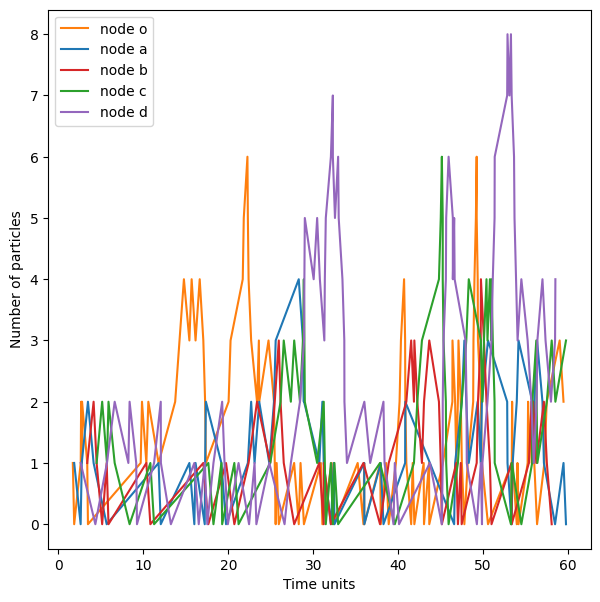

In [98]:
# 3a.1
#start = timer()
nodes_particles_dict, nodes_ticks_dict = simulation(max_time=60, input_rate=1, fixed=False)
#stop = timer()
#total_time = stop-start
#total_time
plot_evolution(input_rate=1, nodes_ticks_dict=nodes_ticks_dict, nodes_particles_dict=nodes_particles_dict,
               fixed=False)

In [99]:
tab_evolution(nodes_particles_dict = nodes_particles_dict, nodes_ticks_dict = nodes_ticks_dict)

,Particles in node o,Poisson clock tick for node o,Particles in node a,Poisson clock tick for node a,Particles in node b,Poisson clock tick for node b,Particles in node c,Poisson clock tick for node c,Particles in node d,Poisson clock tick for node d
0,1.0,1.700741,1.0,1.861360,1.0,2.622888,1.0,3.398704,1.0,4.504147
1,1.0,2.632912,0.0,2.622888,0.0,4.354160,2.0,4.148110,2.0,5.156491
2,1.0,2.681150,1.0,2.752340,1.0,5.719084,1.0,4.504147,1.0,5.719084
3,1.0,2.789559,2.0,3.482577,2.0,6.627508,0.0,5.156491,2.0,5.900284
4,1.0,9.688071,1.0,4.148110,1.0,8.239718,1.0,5.687751,1.0,6.627508
...,...,...,...,...,...,...,...,...,...,...
93,1.0,59.002249,0.0,59.746022,4.0,56.977251,0.0,58.063609,3.0,59.746022
94,1.0,59.002249,0.0,59.746022,3.0,57.338991,0.0,58.063609,3.0,59.746022
95,1.0,59.002249,0.0,59.746022,2.0,57.975464,0.0,58.063609,3.0,59.746022
96,1.0,59.002249,0.0,59.746022,3.0,58.459993,0.0,58.063609,3.0,59.746022


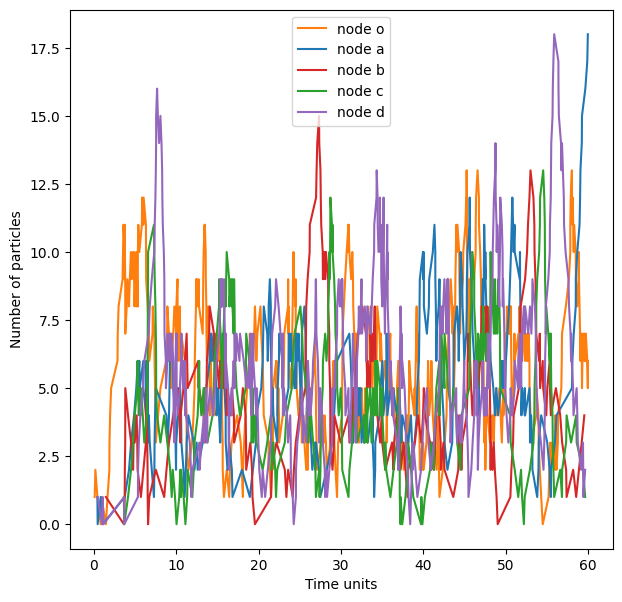

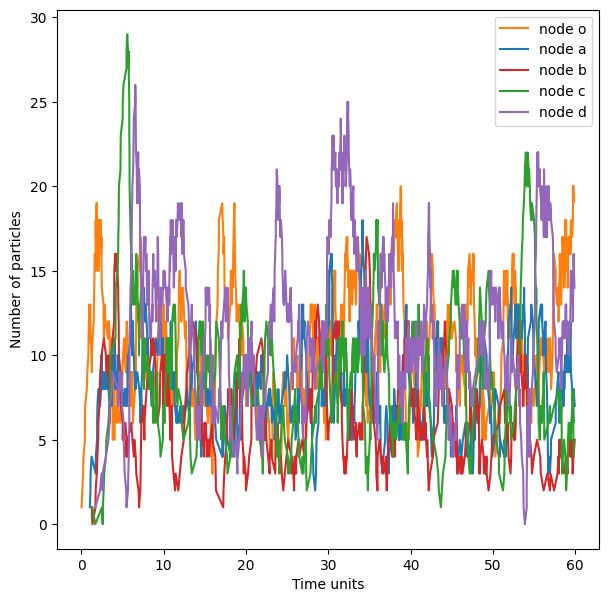

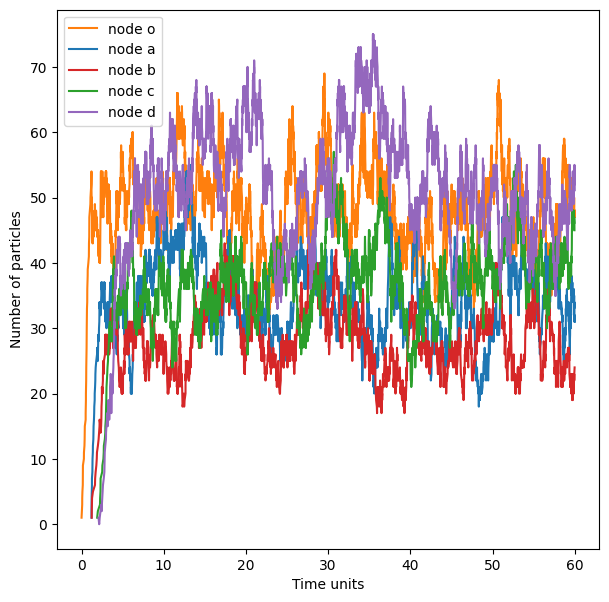

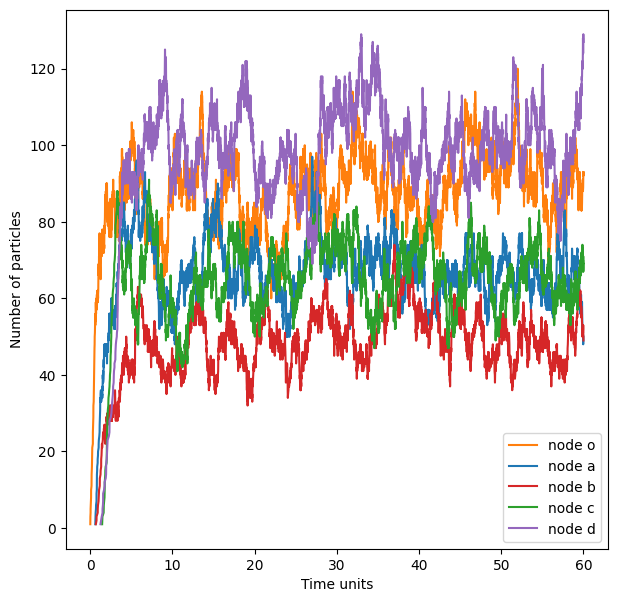

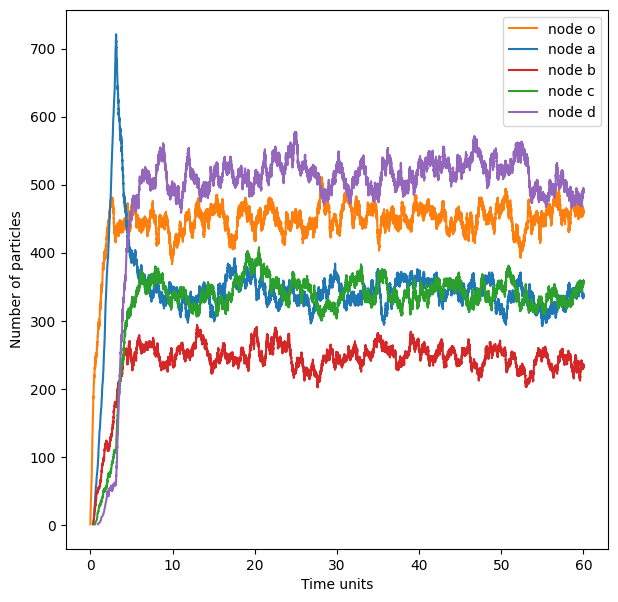

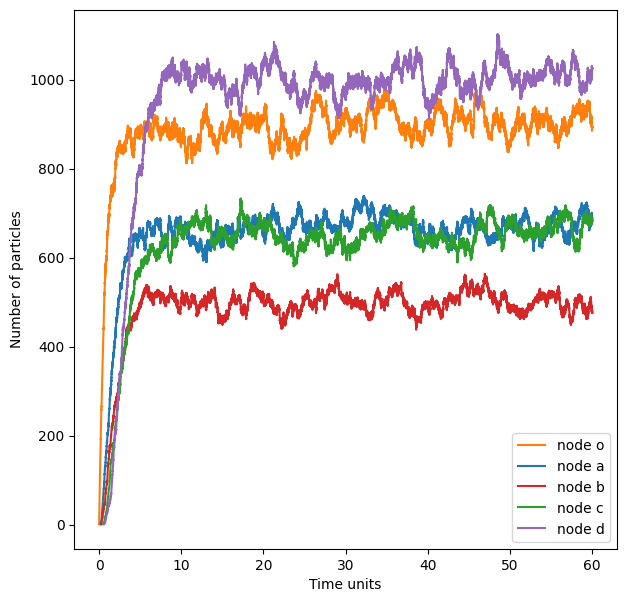

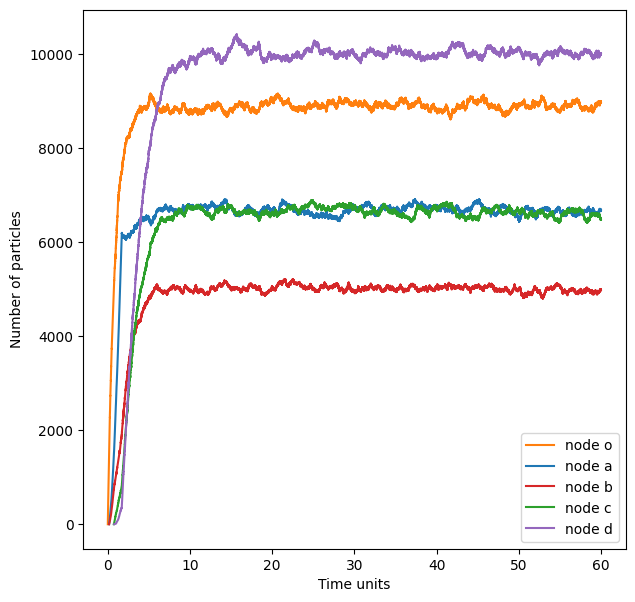

In [100]:
# 3a.2
#total_time = []
for ir in [5, 10, 50, 100, 500, 1000, 10000]:
    #start = timer()
    nodes_particles_dict, nodes_ticks_dict = simulation(max_time=60, input_rate=ir, fixed=False)
    #stop = timer()
    #total_time.append(stop-start)
    plot_evolution(ir, nodes_ticks_dict, nodes_particles_dict, fixed=False)

### Problem 3.b. - Fixed Rate
Each node $i$ will pass along particles with a fixed rate $\omega$.

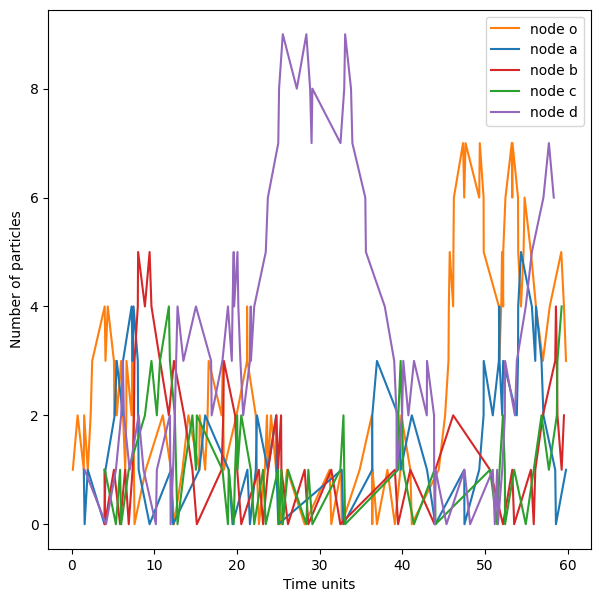

In [132]:
# 3b.1
#start = timer()
nodes_particles_dict, nodes_ticks_dict = simulation(max_time=60, input_rate=1, fixed=True)
#stop = timer()
plot_evolution(input_rate=1, nodes_ticks_dict=nodes_ticks_dict, nodes_particles_dict=nodes_particles_dict,
               fixed=True)

In [131]:
tab_evolution(nodes_particles_dict = nodes_particles_dict, nodes_ticks_dict = nodes_ticks_dict)

,Particles in node o,Poisson clock tick for node o,Particles in node a,Poisson clock tick for node a,Particles in node b,Poisson clock tick for node b,Particles in node c,Poisson clock tick for node c,Particles in node d,Poisson clock tick for node d
0,1.0,0.269238,1.0,0.656275,1.0,0.983754,1.0,1.421567,1.0,2.305994
1,1.0,1.376829,0.0,0.983754,0.0,1.421567,0.0,1.874780,0.0,3.257761
2,1.0,2.069859,1.0,2.107743,1.0,3.213809,1.0,3.215511,1.0,4.549773
3,1.0,4.355251,0.0,3.213809,0.0,3.215511,0.0,3.330206,0.0,5.100801
4,1.0,4.435159,1.0,4.840182,1.0,3.257761,1.0,4.544506,1.0,5.339634
...,...,...,...,...,...,...,...,...,...,...
99,1.0,59.010622,0.0,53.944762,0.0,58.161529,6.0,56.870312,3.0,59.772100
100,1.0,59.010622,0.0,53.944762,0.0,58.161529,7.0,58.042259,3.0,59.772100
101,1.0,59.010622,0.0,53.944762,0.0,58.161529,8.0,58.161529,3.0,59.772100
102,1.0,59.010622,0.0,53.944762,0.0,58.161529,7.0,58.756502,3.0,59.772100


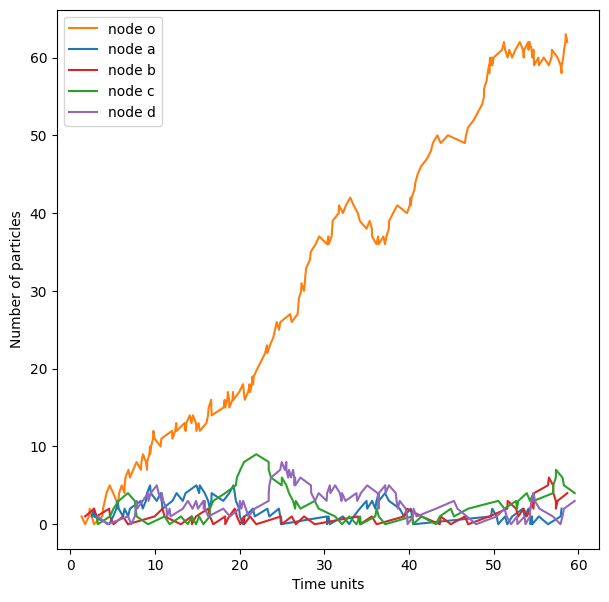

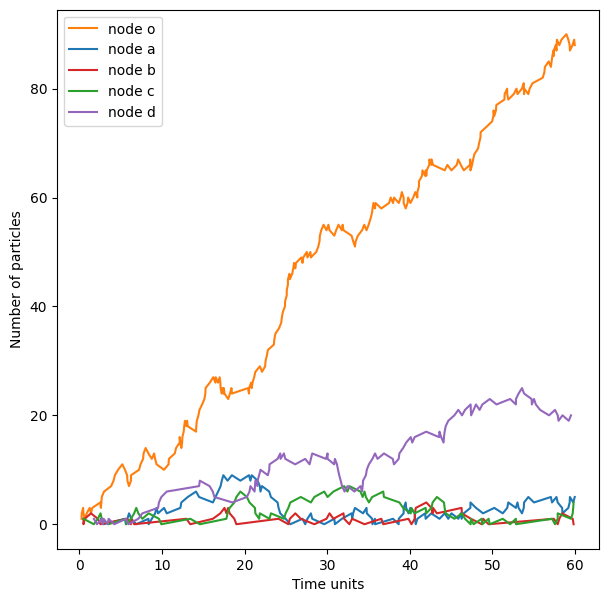

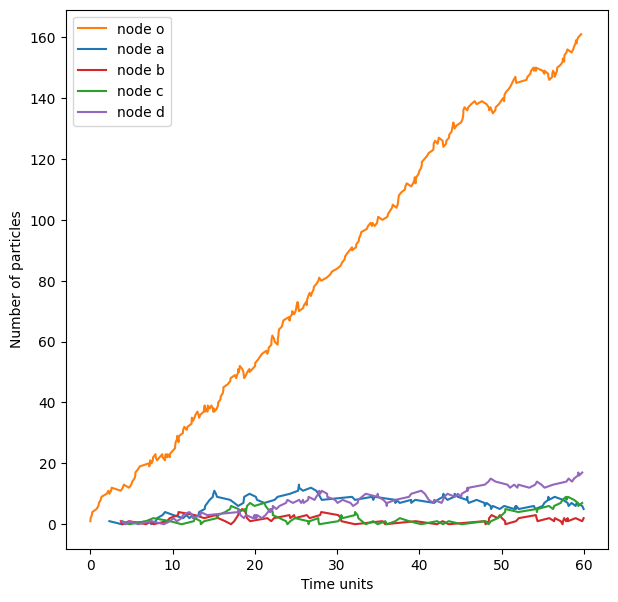

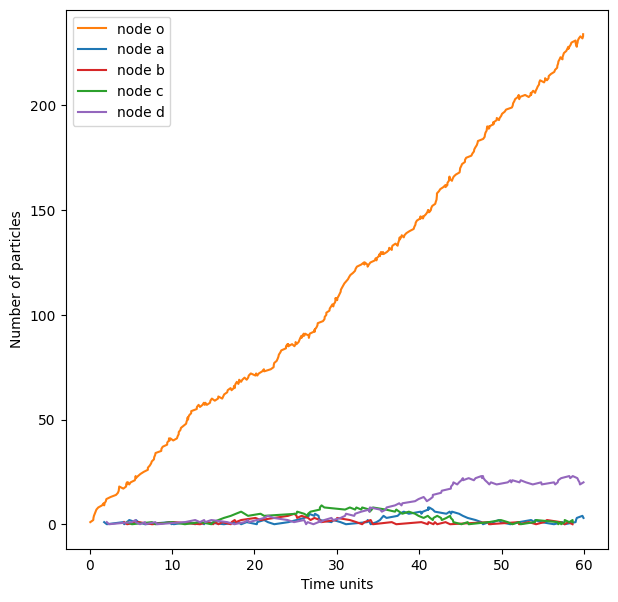

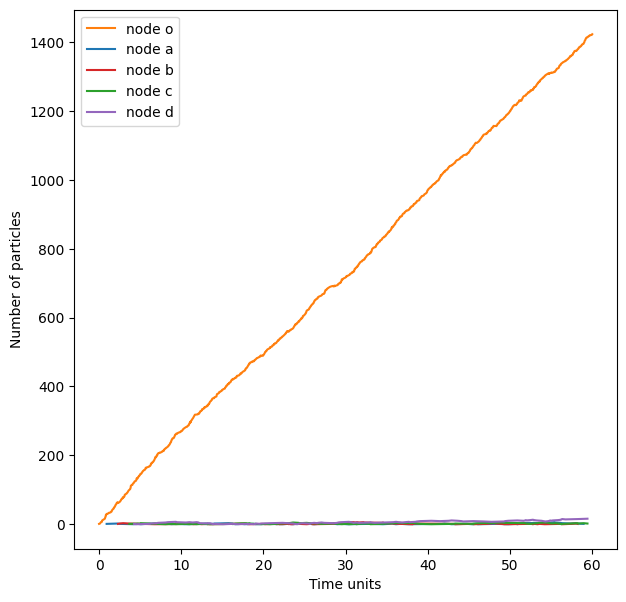

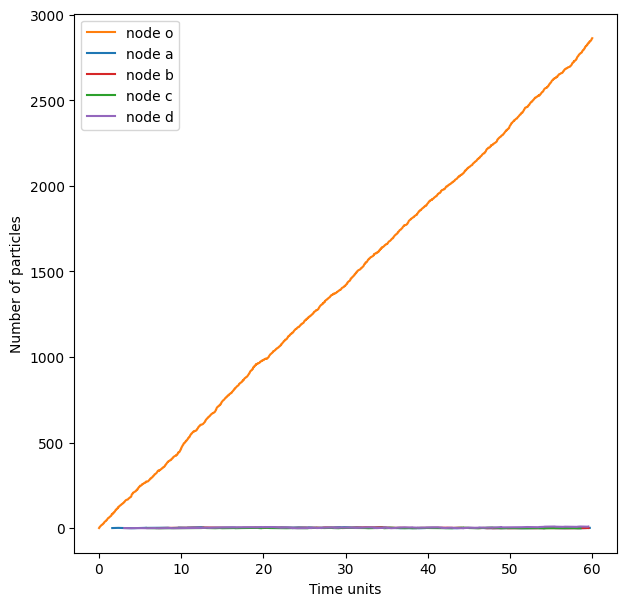

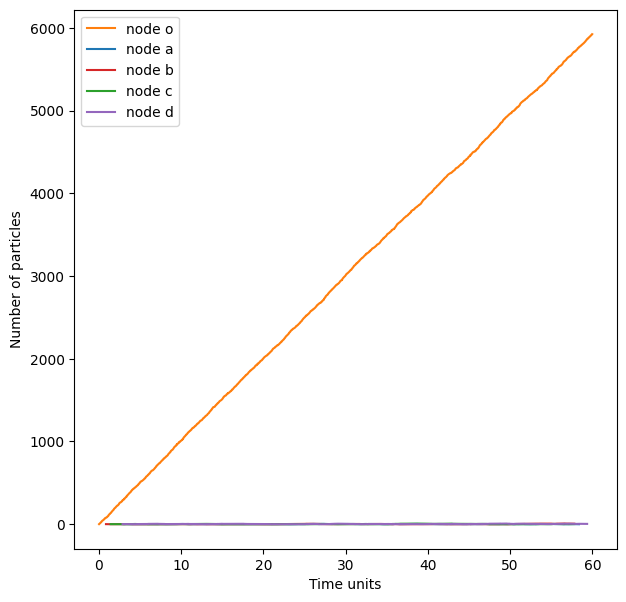

In [102]:
# 3b.2
#total_time = []
for ir in [2, 3, 4, 5, 25, 50, 100]:
    #start = timer()
    nodes_particles_dict, nodes_ticks_dict = simulation(max_time=60, input_rate=ir, fixed=True)
    #stop = timer()
    #total_time.append(stop-start)
    plot_evolution(ir, nodes_ticks_dict, nodes_particles_dict, fixed=True)